# Installations and libraries

In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk.utils
!pip install -q gurobipy
!apt-get install -y -qq coinor-cbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 47.2 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 122541 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.11.4+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.108.6+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-2_amd64.deb .

In [ ]:
from itertools import product, combinations
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Input data

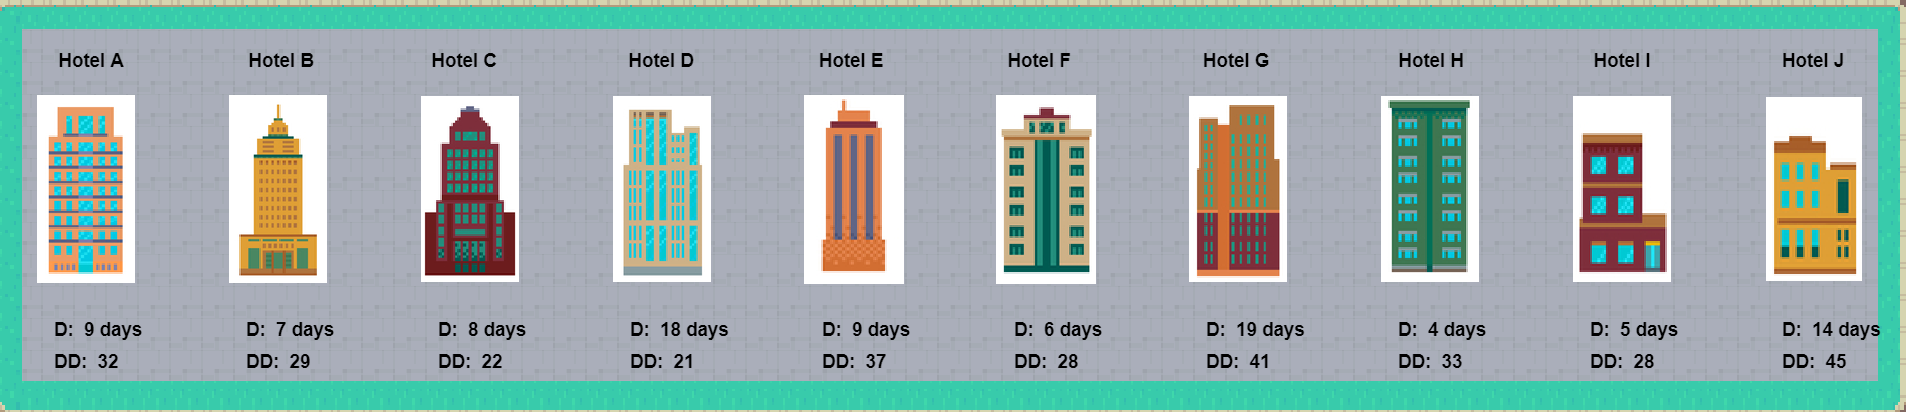

In [ ]:
jobs_keys = list('ABCDEFGHIJ')
durations = [9,7,8,18,9,6,19,4,5,14]
due_dates = [32,29,22,21,37,28,41,33,28,45]

In [ ]:
data = dict()
for i in range(len(jobs_keys)):
  data[jobs_keys[i]] = {'duration':durations[i],'due':due_dates[i]}

In [ ]:
data

{'A': {'duration': 9, 'due': 32},
 'B': {'duration': 7, 'due': 29},
 'C': {'duration': 8, 'due': 22},
 'D': {'duration': 18, 'due': 21},
 'E': {'duration': 9, 'due': 37},
 'F': {'duration': 6, 'due': 28},
 'G': {'duration': 19, 'due': 41},
 'H': {'duration': 4, 'due': 33},
 'I': {'duration': 5, 'due': 28},
 'J': {'duration': 14, 'due': 45}}

In [ ]:
prod = list(combinations(jobs_keys,2))

In [ ]:
prod

[('A', 'B'),
 ('A', 'C'),
 ('A', 'D'),
 ('A', 'E'),
 ('A', 'F'),
 ('A', 'G'),
 ('A', 'H'),
 ('A', 'I'),
 ('A', 'J'),
 ('B', 'C'),
 ('B', 'D'),
 ('B', 'E'),
 ('B', 'F'),
 ('B', 'G'),
 ('B', 'H'),
 ('B', 'I'),
 ('B', 'J'),
 ('C', 'D'),
 ('C', 'E'),
 ('C', 'F'),
 ('C', 'G'),
 ('C', 'H'),
 ('C', 'I'),
 ('C', 'J'),
 ('D', 'E'),
 ('D', 'F'),
 ('D', 'G'),
 ('D', 'H'),
 ('D', 'I'),
 ('D', 'J'),
 ('E', 'F'),
 ('E', 'G'),
 ('E', 'H'),
 ('E', 'I'),
 ('E', 'J'),
 ('F', 'G'),
 ('F', 'H'),
 ('F', 'I'),
 ('F', 'J'),
 ('G', 'H'),
 ('G', 'I'),
 ('G', 'J'),
 ('H', 'I'),
 ('H', 'J'),
 ('I', 'J')]

# Naive schedule FCFS (First Comes First Served)

In [ ]:
FCFS_schedule = {}
start = 0
for act in data:
  act_schd = {}
  act_schd['start'] = start
  act_schd['finish'] = start + data[act]['duration']
  FCFS_schedule[act] = act_schd
  start =  act_schd['finish']

In [ ]:
FCFS_schedule

{'A': {'start': 0, 'finish': 9},
 'B': {'start': 9, 'finish': 16},
 'C': {'start': 16, 'finish': 24},
 'D': {'start': 24, 'finish': 42},
 'E': {'start': 42, 'finish': 51},
 'F': {'start': 51, 'finish': 57},
 'G': {'start': 57, 'finish': 76},
 'H': {'start': 76, 'finish': 80},
 'I': {'start': 80, 'finish': 85},
 'J': {'start': 85, 'finish': 99}}

In [ ]:
past_due_days = 0
for act in FCFS_schedule:

  if FCFS_schedule[act]['finish'] > data[act]['due']:
    past_due_days += FCFS_schedule[act]['finish'] - data[act]['due']
print(f'Total number of days of delay = {past_due_days}')

Total number of days of delay = 259


# Mathematical Programming Model

In [ ]:
# create model
m = pyo.ConcreteModel()

## Variables

In [ ]:
m.JOBS = pyo.Set(initialize = data.keys())

In [ ]:
m.PAIRS = pyo.Set(initialize = prod)

In [ ]:
m.start = pyo.Var(m.JOBS, domain = pyo.NonNegativeReals)
#m.finish = pyo.Var(m.JOBS, domain = pyo.NonNegativeReals)
m.pastdue = pyo.Var(m.JOBS, domain = pyo.NonNegativeReals)
m.y = pyo.Var(m.PAIRS, domain = pyo.Binary)

In [ ]:
#m.makespan   = pyo.Var(domain = pyo.NonNegativeReals)

## Objective function

In [ ]:
m.OBJ = pyo.Objective(expr = sum(m.pastdue[j] for j in m.JOBS), sense = pyo.minimize)

## Constraints

In [ ]:
m.c = pyo.ConstraintList()
for j in m.JOBS:
    #m.c.add(m.finish[j] == m.start[j] + data[j]['duration'])
    #m.c.add(m.start[j] + data[j]['duration'] <= m.makespan)
    m.c.add(m.start[j] + data[j]['duration'] <= data[j]['due'] + m.pastdue[j])

In [ ]:
M = sum([data[x]['duration'] for x in data])
M

99

In [ ]:
for j,k in m.PAIRS:
    m.c.add(m.start[j] + data[j]['duration'] <= m.start[k] + M*m.y[j,k])
    m.c.add(m.start[k] + data[k]['duration'] <= m.start[j] + M*(1 - m.y[j,k]))

## Run the model

In [ ]:
m.pprint()

3 Set Declarations
    JOBS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'}
    PAIRS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :   45 : {('A', 'B'), ('A', 'C'), ('A', 'D'), ('A', 'E'), ('A', 'F'), ('A', 'G'), ('A', 'H'), ('A', 'I'), ('A', 'J'), ('B', 'C'), ('B', 'D'), ('B', 'E'), ('B', 'F'), ('B', 'G'), ('B', 'H'), ('B', 'I'), ('B', 'J'), ('C', 'D'), ('C', 'E'), ('C', 'F'), ('C', 'G'), ('C', 'H'), ('C', 'I'), ('C', 'J'), ('D', 'E'), ('D', 'F'), ('D', 'G'), ('D', 'H'), ('D', 'I'), ('D', 'J'), ('E', 'F'), ('E', 'G'), ('E', 'H'), ('E', 'I'), ('E', 'J'), ('F', 'G'), ('F', 'H'), ('F', 'I'), ('F', 'J'), ('G', 'H'), ('G', 'I'), ('G', 'J'), ('H', 'I'), ('H', 'J'), ('I', 'J')}
    c_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     

In [ ]:
opt = SolverFactory('gurobi')

In [ ]:
results = opt.solve(m,tee=True)

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file /tmp/tmpx66f8fds.pyomo.lp
Reading time = 0.00 seconds
x1: 100 rows, 65 columns, 290 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 100 rows, 65 columns and 290 nonzeros
Model fingerprint: 0x1d93330a
Variable types: 20 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+02]
Found heuristic solution: objective 194.0000000
Presolve time: 0.00s
Presolved: 100 rows, 65 columns, 290 nonzeros
Variable types: 20 continuous, 45 integer (45 binary)

Root relaxation: objective 0.000000e+00, 51 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node  

In [ ]:
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1
  Lower bound: 152.0
  Upper bound: 152.0
  Number of objectives: 1
  Number of constraints: 100
  Number of variables: 65
  Number of binary variables: 45
  Number of integer variables: 45
  Number of continuous variables: 20
  Number of nonzeros: 290
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (su

# Extract the solution

In [ ]:
pyo.value(m.OBJ)

152.0

In [ ]:
SCHEDULE = dict()
for j in m.JOBS:
  SCHEDULE[j] = {'JOB': j,
                 'start':round(pyo.value(m.start[j]),0),
                 'finish':round(pyo.value(m.start[j]),0) + data[j]['duration'],
                 'due':data[j]['due'],
                 'delay':round(pyo.value(m.pastdue[j]),0)}

In [ ]:
SCHEDULE

{'A': {'JOB': 'A', 'start': 30.0, 'finish': 39.0, 'due': 32, 'delay': 7.0},
 'B': {'JOB': 'B', 'start': 14.0, 'finish': 21.0, 'due': 29, 'delay': 0.0},
 'C': {'JOB': 'C', 'start': 0.0, 'finish': 8.0, 'due': 22, 'delay': 0.0},
 'D': {'JOB': 'D', 'start': 62.0, 'finish': 80.0, 'due': 21, 'delay': 59.0},
 'E': {'JOB': 'E', 'start': 39.0, 'finish': 48.0, 'due': 37, 'delay': 11.0},
 'F': {'JOB': 'F', 'start': 8.0, 'finish': 14.0, 'due': 28, 'delay': 0.0},
 'G': {'JOB': 'G', 'start': 80.0, 'finish': 99.0, 'due': 41, 'delay': 58.0},
 'H': {'JOB': 'H', 'start': 26.0, 'finish': 30.0, 'due': 33, 'delay': 0.0},
 'I': {'JOB': 'I', 'start': 21.0, 'finish': 26.0, 'due': 28, 'delay': 0.0},
 'J': {'JOB': 'J', 'start': 48.0, 'finish': 62.0, 'due': 45, 'delay': 17.0}}

In [ ]:
a = np.array([x for x in SCHEDULE])

In [ ]:
order = list(np.array([SCHEDULE[x]['start'] for x in SCHEDULE]).argsort())

In [ ]:
a = a[order].tolist()

In [ ]:
a

['C', 'F', 'B', 'I', 'H', 'A', 'E', 'J', 'D', 'G']

# Plot the solution

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

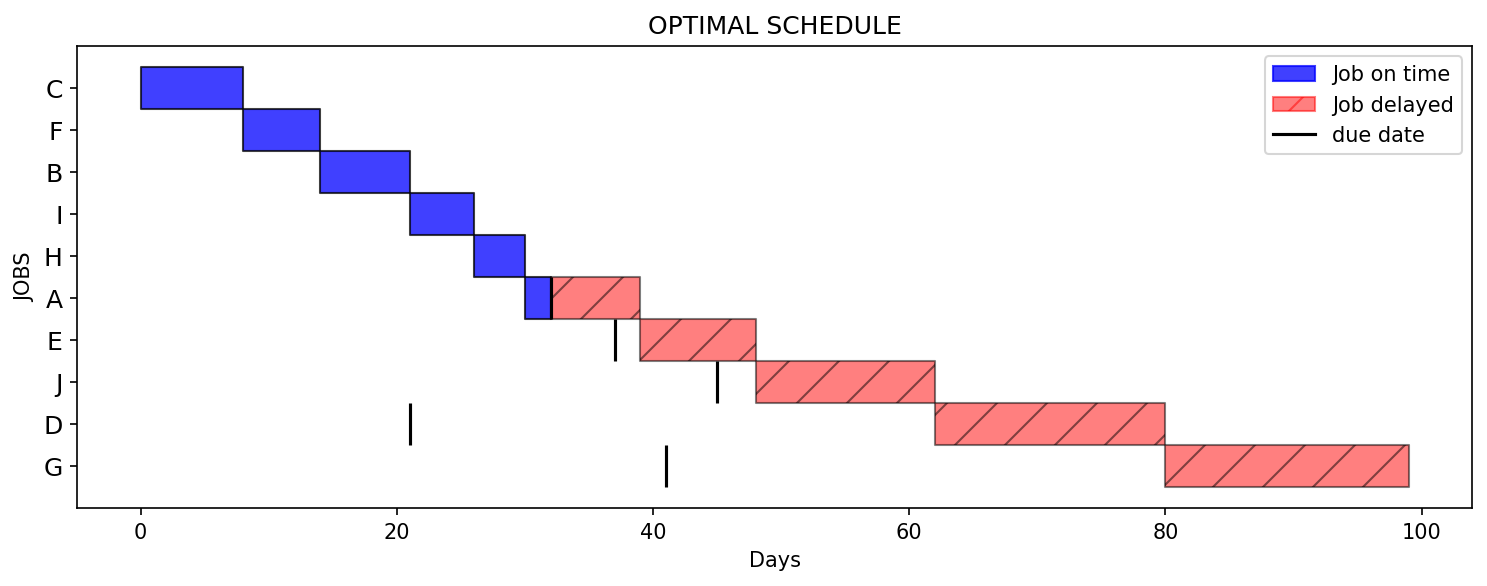

In [ ]:
Y_idx = []
y = len(a)
plt.figure(figsize = (12,4),dpi = 150)

for act in a:
  start = SCHEDULE[act]['start']
  dur = data[act]['duration']
  due_date = data[act]['due']
  finish = start + dur

  Y_idx.append(y-0.5)
  y -= 1

  if finish > due_date:
    if start >= due_date:
      plt.broken_barh(xranges=[(start, dur)], yrange=(y, 1),color = 'red',hatch='/',alpha = 0.5,edgecolor = 'black')
      plt.vlines(x = due_date,ymin = y , ymax = y + 1,color = 'black')
    else:
      plt.broken_barh(xranges=[(start, due_date-start)], yrange=(y, 1),color = 'blue',alpha = 0.75,edgecolor = 'black')
      plt.broken_barh(xranges=[(due_date, finish - due_date)], yrange=(y, 1),color = 'red',alpha = 0.5,hatch='/',edgecolor = 'black')
      plt.vlines(x = due_date,ymin = y , ymax = y + 1,color = 'black',label = 'due-date')
  else:
    plt.broken_barh(xranges=[(start, dur)], yrange=(y, 1),color = 'blue',alpha = 0.75,edgecolor = 'black')

plt.yticks(ticks=Y_idx, labels = a, fontsize=12)
plt.xlabel('Days')
plt.ylabel('JOBS')
plt.title('OPTIMAL SCHEDULE')

on_time = mpatches.Patch(color='blue',alpha = 0.75, label='Job on time')
delayed = mpatches.Patch(color='red',alpha = 0.5,hatch='/', label='Job delayed')
line = Line2D([0], [0], label='due date', color='k')

handles = [on_time,delayed,line]
plt.legend(handles=handles)
plt.savefig('schedule.jpg')
plt.show()